# Final Project

In this notebook, we explore locations and their ratings

## Load Libraries

In [10]:
import json
import requests # library to handle requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# For maps
import folium
from geopy.geocoders import Nominatim

## Introduction / Business Problem

Entrepreneurs are interested in starting new franchises and need to choose a good location.

### Initial Question

Where should someone looking to start a franchise restaurant (e.g., Taco Bell) open a new location?


### Discussion

Typically this involves determining the overlap between a franchise's target customer and the location's demographics. Instead, we consider a restaurant's rating as a substitute for potential success as a business. The greater a restaurant's rating, the more likely customers will want to go to that location. We will be using Foursquare API to pull restaurant data for various franchises and determine whether or not location has an impact on ratings.

### Refined Question

How does a restuarant's location have an impact on the ratings? (specifically for franchises such as Taco Bell or Pizza Hut)

## Data

We will be using Foursquare API which provides rich information on venues in a specific location and details on each venue. See https://developer.foursquare.com/docs/api-reference/venues/details for all the response fields.

The columns we collect are the Foursquare ID (used to pull the rating), restaurant name, latitude, longitude, city, and Foursquare rating.

For example, an entrepreneur may be looking to start a new Taco Bell location. So we can look at all restaurants in the data with "Taco Bell" in the name. One such entry has ID `4bf60608004ed13a4fe141a0`, name `Taco Bell`, latitude `34.069499`, longitude `-118.277301`, city `Los Angeles`, and rating `6.4`.

## Other

We can potentially use this data to perform a KNN regression and predict restaurant ratings based on their k nearest neighbors. The resulting accuracy of such a model will suggest whether or not location has an impact on a restaurant's rating.

In [2]:
# Load Credentials from a file
with open("secret.json", "r") as f:
    secret = json.load(f)
    
CLIENT_ID = secret["CLIENT_ID"]
CLIENT_SECRET =secret["CLIENT_SECRET"]
VERSION = '20180605'
LIMIT = 200

In [3]:
def get_nearby_venues(search_term, latitude, longitude, radius=500):
    url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
    url = url + f'&ll={latitude},{longitude}&intent=browse&radius={radius}&query={search_term}&limit={LIMIT}'

    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
    except:
        raise
        results = []
        
    data = []
    for result in results:
        venue = result['venue']
        
        venue_id = venue['id']
        name = venue['name']
        lat = venue['location']['lat']
        lng = venue['location']['lng']
        city = venue['location']['city']
        
        data.append([venue_id, name, lat, lng, city])
        
    return data

In [4]:
def get_rating(venue_ID):
    url = f'https://api.foursquare.com/v2/venues/{venue_ID}?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'

    try:
        rating = requests.get(url).json()["response"]['venue']['rating']
    except:
        rating = float('nan')
    
    return rating

In [5]:
def assemble_dataset(search_term, latitude, longitude):
    data = get_nearby_venues(search_term, latitude, longitude)
    df = pd.DataFrame(data, columns=["ID", "Name", "Latitude", "Longitude", "City"])
    df["rating"] = df["ID"].map(get_rating)
    return df

In [42]:
LA_lat, LA_lng = (34.052235, -118.243683) # latitude and longitude of Los Angeles
# df1 = assemble_dataset("Taco Bell", LA_lat, LA_lng)
# df1.to_csv("./foursquare_data/LA - Taco Bell.csv")
df1 = pd.read_csv("./foursquare_data/LA - Taco Bell.csv", index_col=0)

OC_lat, OC_lng = (33.7175, -117.8311) # latitude and longitude of Orange County
# df2 = assemble_dataset("Taco Bell", OC_lat, OC_lng)
# df2.to_csv("./foursquare_data/OC - Taco Bell.csv")
df2 = pd.read_csv("./foursquare_data/OC - Taco Bell.csv", index_col=0)

# Fill in data between the two locations.
midpoint_lat = (OC_lat+LA_lat)/2
midpoint_lng = (OC_lng+LA_lng)/2
# df3 = assemble_dataset("Taco Bell", midpoint_lat, midpoint_lng)
# df3.to_csv("./foursquare_data/Between LA and OC - Taco Bell.csv")
df3 = pd.read_csv("./foursquare_data/Between LA and OC - Taco Bell.csv", index_col=0)

drop_names = ["Taco Bell/Pizza Hut", "Taco Bell/KFC"]
df = pd.concat([df1, df2, df3]).drop_duplicates().dropna()
df = df[~df["Name"].isin(drop_names)]
df.head()

,ID,Name,Latitude,Longitude,City,rating
1,4bf60608004ed13a4fe141a0,Taco Bell,34.069499,-118.277301,Los Angeles,6.6
3,4bbd3db1593fef3b134f0356,Taco Bell,34.026572,-118.276245,Los Angeles,6.9
4,4b6b8de9f964a520990f2ce3,Taco Bell,34.079886,-118.259858,Los Angeles,5.4
5,4bc64e3db387d13a33b0c1e8,Taco Bell,34.073864,-118.212878,Los Angeles,5.7
6,4b6612b7f964a52026122be3,Taco Bell,34.057912,-118.292545,Los Angeles,5.8


In [84]:
df["rating"].describe()

count    94.000000
mean      6.142553
std       0.574454
min       4.700000
25%       5.800000
50%       6.100000
75%       6.575000
max       7.500000
Name: rating, dtype: float64

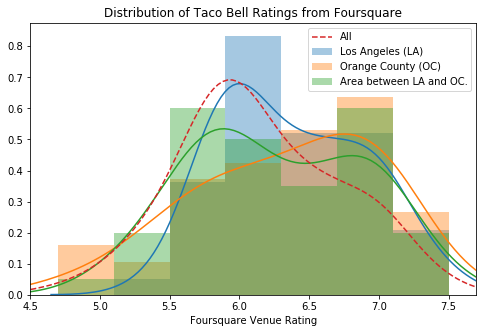

In [111]:
plt.figure(figsize=(8,5))
bins = np.linspace(4.7, 7.5, 8)
sns.distplot(df1["rating"].dropna(), bins=bins, label="Los Angeles (LA)")
sns.distplot(df2["rating"].dropna(), bins=bins, label="Orange County (OC)")
sns.distplot(df3["rating"].dropna(), bins=bins, label="Area between LA and OC.")
sns.distplot(df["rating"], bins=bins, hist=False, label="All", kde_kws={"linestyle": "--"})
plt.title("Distribution of Taco Bell Ratings from Foursquare")
plt.legend()
plt.xlim(4.5, 7.7)
plt.xlabel("Foursquare Venue Rating")
plt.show()

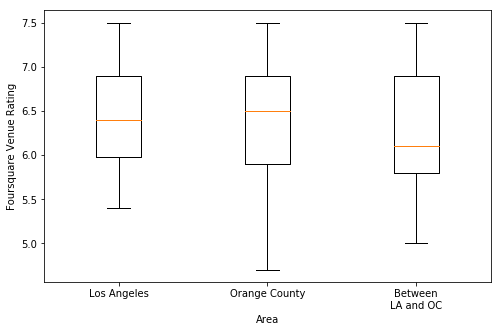

In [108]:
fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot([d[~d["Name"].isin(drop_names)].dropna()["rating"] for d in [df1, df2, df3]])
plt.xticks([1, 2, 3], ["Los Angeles", "Orange County", "Between\nLA and OC"])
plt.xlabel("Area")
plt.ylabel("Foursquare Venue Rating")
plt.show()

In [116]:
latitude = midpoint_lat
longitude = midpoint_lng

map_la_and_oc = folium.Map(location=[latitude, longitude], zoom_start=10)

high_cutoff = np.percentile(df['rating'].dropna(), 66)
low_cutoff = np.percentile(df['rating'].dropna(), 33)

print(low_cutoff, high_cutoff)

# add markers to map
for lat, lng, name, rating in zip(df['Latitude'], df['Longitude'],
                                  df['Name'], df['rating']):
    label = f'{name}, {rating}'
    label = folium.Popup(label, parse_html=True)
    
    if rating:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green' if rating > high_cutoff else ('yellow' if rating > low_cutoff else "red"),
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_la_and_oc)  
        
map_la_and_oc

5.869 6.338


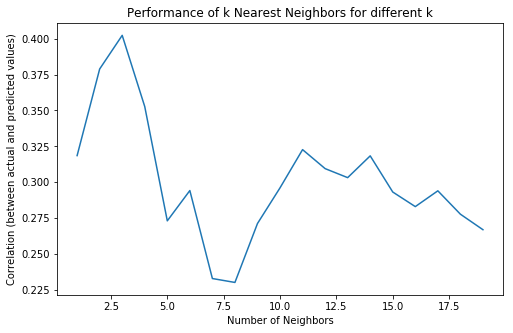

In [183]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
import scipy.stats

X = df[["Latitude", "Longitude"]]

X = df[["Latitude", "Longitude"]]
y = df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

loo = LeaveOneOut()

y_scores = []
for k in range(1, 20):
    knr = KNeighborsRegressor(n_neighbors=k, metric="haversine")
    
    y_actual = []
    y_pred = []
    for train_index, val_index in loo.split(X_train):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]
        knr.fit(X_train_k, y_train_k)
        y_pred_k = knr.predict(X_val_k)
        y_actual.extend(y_val_k)
        y_pred.append(y_pred_k[0])
    y_scores.append(scipy.stats.pearsonr(y_actual, y_pred)[0])

plt.figure(figsize=(8,5))
plt.plot(range(1, 20), y_scores)
plt.xlabel("Number of Neighbors")
plt.ylabel("Correlation (between actual and predicted values)")
plt.title("Performance of k Nearest Neighbors for different k")
plt.show()

In [180]:
knr = KNeighborsRegressor(n_neighbors=3, metric="haversine")
knr.fit(X_train, y_train)

y_pred = knr.predict(X_test)

scipy.stats.pearsonr(y_test, y_pred)[0]

# Build a linear regression.
result = scipy.stats.linregress(y_train, knr.predict(X_train))
print(f"y_train_pred ~ {result.slope:.3f}*y + {result.intercept:.3f}, r={result.rvalue:.4f}")

y_train_pred ~ 0.517*y + 2.927, r=0.7557


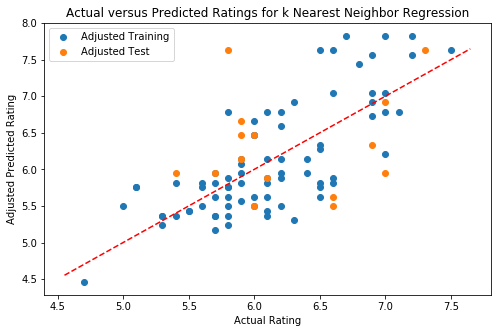

In [181]:
plt.figure(figsize=(8,5))

plt.scatter(y_train, [(x-result.intercept)/result.slope for x in knr.predict(X_train)], label="Adjusted Training")
plt.title("Actual versus Predicted Ratings for k Nearest Neighbor Regression")
plt.xlabel("Actual Rating")
plt.ylabel("Adjusted Predicted Rating")

x_values = plt.xlim()

# Plot identity.
plt.plot(x_values, x_values, color="red", linestyle="--")

plt.scatter(y_test, [(x-result.intercept)/result.slope for x in y_pred], label="Adjusted Test")

plt.legend()
plt.show()

In [188]:
# Mean squared error
sum([((x-result.intercept)/result.slope - y)**2 for x, y in zip(knr.predict(X_train), y_train)])/len(y_train)

0.29272272884542777

In [190]:
# Mean squared predicted error
sum([((x-result.intercept)/result.slope - y)**2 for x, y in zip(y_pred, y_test)])/len(y_pred)

0.08818447537677274

In [195]:
# Mean squared error using the average value of the training set.
sum([(np.mean(y_train) - y)**2 for y in y_train])/len(y_pred)

0.3260150616888321

In [196]:
# Mean squared predicted error using the average value of the training set.
sum([(np.mean(y_train) - y)**2 for y in y_test])/len(y_pred)

0.06319694790878609